# Applications de la décomposition sparse en facteurs latents aux systèmes de recommandation

__Contenu du Notebook__

Ce Notebook contient : 
- **une présentation** rapide du projet, son contexte, les modèles développés ainsi que les méthodes de résolution que j'ai utilisées
- le **code que j'ai produit pour le projet** qui peut se répartir en 3 parties : **Data Integration/preprocessing**, **modélisation/résolution** et enfin **expérimentations et visualisation des résultats**.

**La présentation PowerPoint jointe dans le dépot Github du projet est plus complète que cette courte introduction au projet**, qui est plutôt un complément au contenu de ce support.

** Introduction **

**Ce projet vise à mettre en place différentes méthodes "sparse" de décomposition en facteurs latents**. Ces méthodes ont été développées essentiellement lors de la compétition Netflix et se sont montrées très prometteuses. En effet, la plupart des méthodes de décomposition "classiques" (SVD, non zero matrix factorization) necessitent une matrice dense. Or dans le contexte des Systèmes de Recommandations, la matrice UI (User-Item) qui contient les votes/feedbacks des utilisateurs pour les différents items est très creuse : peu de votes sont généralement observés. Afin de pouvoir appliquer des méthodes classiques de factorisation, il faut donc au préalable "remplir" artificiellement cette matrice. Pour le cas de la décomposition SVD, il est également conseillé d'appliquer la décomposition de manière itérative, factorisant à chaque étape la matrice reconstruite obtenue à partir de la décomposition précédente. Cela a pour effet de compléxifier énormément la factorisation.


Cette classe de méthode de factorisation "sparse" permet de pallier à ce problème en exploitant seulement les votes observés. Il est également possible de perfectionner cette méthode en y incluant des données temporelles et externes (aux votes).

J'ai donc implémenté lors de ce projet 3 d'entre elles que j'ai comparées à une approche "naïve"

** Modèles développés **

Le problème d'optimisation de la décomposition "sparse" est le suivant :




$$ \min_{ p^{*},q^{*}, \alpha}(\sum_{v = (u, i, r_{u,i})} (r_{u,i} - p_u q_i^T)^2) +  \alpha (\|p_u\| +  \| q_i\|)^2) $$


$r_{ui}$ correspond au vote observé de l'utilisateur $u$ pour l'item $i$. Comme précisé en introduction ces votes peuvent prendre des valeurs entières comprises entre 1 et 5.


Dans ce modèle (modèle 0), on a donc 2 matrices de paramètres $p^*$ et $q^*$ de tailles respectives $n_{user} \times k$ et $n_{items} \times k$. k est ici le nombre de dimensions latentes de notre modélisation. Ces matrices représentent respectivement les utilisateurs et les items dans ces dimensions latentes. La "correspondance" entre un utilisateur et un item se calcule donc naturellement par $p_u q_i^T$ aussi appelé terme d'intéraction.

Un modèle légèrement plus complexe fait également intervenir des biais utilisateurs et items qui mesurent respectivement les propensions d'un utilisateur à donner de bonnes notes et d'un film à en obtenir de bonnes. Ce problème se résoud par le problème d'optimisation suivant : 




$$\min_{ p^{*},q^{*}, \mu, b_u, b_i, \alpha}(\sum_{v = (u, i, r_{u,i})} (r_{u,i} -  \mu - b_i - b_u - p_u q_i^T)^2) +  \alpha (\|p_u\|^2 +  \| q_i\|^2 + b_u^2 + b_i^2))$$

Enfin, un modèle plus complexe (modèle1) fait intervenir le temps : les termes d'intéraction et de biais sont dépendants du temps. Ici je n'ai considéré qu'un modèle dans lequel les termes de biais étaient dépendants du temps.

- le terme de biais $b_u$ est maintenant fonction du temps : il possède une partie constante $b_u$ et une partie qui s'exprime comme  $\nu_u \times  \sqrt{|t- \overline{t}|}$ ou $\overline{t}$ est le jour moyen de vote de l'utilisateur $u$

- le terme de biais $b_i$ est également fonction du temps : il peut prendre p valeurs différentes dépendant de la période temporelle du vote considéré. Ici, le temps à été divisé en 4 parties.

Le problème d'optimisation complet associé à cette modélisation est donc par conséquent : 





$$\min_{ p^{*},q^{*}, \mu, b_u, \nu_u, b_i, \alpha}(\sum_{v = (u, i, r_{u,i})} (r_{u,i} -  \mu - b_u -   \nu_u \times \sqrt{|t- \overline{t}|} -  b_{i,t} -p_u q_i^T)^2 +  \alpha (\|p_u\|^2 +  \| q_i\|^2 + b_u^2 + \nu_u^2 + b_{i,t}^2))$$

** Données **

Les données utilisées dans le cadre de ce projet proviennent du Dataset MovieLens 100k qui contient 100k votes réalisés par 1000 utilisateurs différents évaluant 1700 films différents. Les votes peuvent prendre des valeurs de 1 à 5. 

** Méthode de résolution/d'optimisation **

Pour résoudre ces problèmes d'optimisation, j'ai utilisé la méthode de **descente stochastique de gradient** avec des paquets de 200 observations (MiniBatch Stochastic Gradient Descent). J'ai également ajouté une fonction **"d'annealing rate"** permettant d'adapter dynamiquement le taux d'apprentissage lors de la descente. 

Les codes que j'ai produits peuvent paraître très complexes aux premiers abords. J'ai eu l'intention dans ce projet d'utiliser Cython (un langage permettant d'interfacer Python et C/C++), ce qui nécessitait (par simplicité) de manipuler des tableaux Numpy. Ainsi, je me suis forcé à utiliser des structures de données bien spécifiques qui alourdissent considérablement le code. Obtenant des gains de temps trop faibles (2x-5x) par rapport au temps consacré à adapter le code Python à Cython, je n'ai finalement pas retenu cette solution.

Par ailleurs, j'ai produit une fonction de descente par modèle, bien que cette fonction aurait pu être "mutualisée". J'ai fait ce choix car chaque descente, pour les modèles de décomposition, fonctionnait mieux si paramétrisée différemment (nombre maximal d'itérations, nombre de "learning rate decay" maximal, etc.). Il était donc plus facile de procéder comme-ceci lors de mes expérimentations.

**Pour chaque modèle, une fonction de descente, une fonction de gradient, une fonction objective et une fonction permettant de prédire des votes ont donc été implémentées.** 

**Pour chaque modèle, un code d'execution simple et un code de Cross-Validation ont été développés.**

** Résultats expérimentaux et visualisation **

J'ai comparé les **performances (score RMSE) de ces 4 modèles (3 décompositions et un modèle naïf) sans régularisation**. Les estimations des performances ont été obtenues par Cross Validation (temps d'éxécution de plusieurs dizaine de minutes par modèle évalué).

Puis, dans un second temps, je n'ai conservé que le meilleur modèle obtenu pour **analyser l'influence du paramètre de régularisation sur ses performances afin d'éventuellement déterminer un meilleur modèle**.

Enfin, dans une dernière partie, j'ai tenté de **visualiser et comprendre ce que représentaient les dimensions latentes obtenues pour 2 modèles différents** :

- le meilleur modèle obtenu au cours de mes expérimentations (modèle 1 avec un coefficient de régularisation de 0.1 et 2 dimensions latentes)
- un "bon" modèle (modèle1) avec 10 dimensions latentes dont je n'ai conservé que les 2 possédant les variances les plus importantes.

J'ai, à l'issue de mes expérimentations **sauvegarder les objets Python contenant toutes les informations utiles** (erreurs d'entrainement et validation cross-validées pour chacun des modèles testées). Ces résultats sont présentés dans la dernière partie du Notebook.

In [4]:
import numpy as np
import pandas as pd
import random as rnd
from numpy import linalg as la
import time
import matplotlib.pyplot as plt
import datetime
import pickle

%matplotlib inline
plt.rc('figure', figsize=(14, 7))

SEED = 666
rnd.seed(SEED)

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


## I\ Data Integration, Preprocessing and Features Engineering

### Utility functions

In [1]:
def make_random_bins(observations, bin_size):
    n_obs = len(observations)
    shuffled_obs = observations
    rnd.shuffle(shuffled_obs)

    bins = [shuffled_obs[k*bin_size:(k+1)*bin_size] for k in range(n_obs//bin_size-1)]

    if n_obs % bin_size != 0:
        bins.append(shuffled_obs[n_obs//bin_size:])

    return bins


def make_bins_i(n_obs, bin_size):
    bins_indexes = []
    bins_indexes.append(0)
    bins_indexes = [k * bin_size for k in range(n_obs//bin_size)]
    bins_indexes.append(n_obs)
    return(bins_indexes)

# test
obs = [(1, 4, 3), (2, 7, 5), (4, 8, 2), (1, 3, 5), (3, 6, 5), (2, 1, 3)]
make_bins_i(6, 3)

[0, 3, 6]

### Data Integration/preprocessing

Les principales tâches réalisées lors de cette étape sont : 

- construction de la matrice UI (User-Item)
- construction des features "Date" et "Jour" pour les votes
- construction des features "Date de sortie" et "Jours depuis la date de sortie"
- construction des features "Jour de vote moyen" et $ \sqrt{|t- \overline{t}|}$ ou $t$ est le jour du vote pour l'utilisateur ayant produit le vote
- construction de la feature "DateBin" dénotant la pédiode temporelle au cours de laquelle a été réalisée le vote

In [4]:
ratings = pd.read_csv('./data/u.data.csv', sep='|')
itemsdf = pd.read_csv('./data/u.item.csv', sep='|')
usersdf = pd.read_csv('./data/u.user.csv', sep='|')

# Compute UI matrix
UI = ratings.pivot(index='user.id', columns='item.id', values='rating')

# Compute list of unique users/items
items = ratings['item.id'].unique()
n_items = len(items)
users = ratings['user.id'].unique()
n_users = len(users)

itemid_to_rank = {items[k]: k for k in range(len(items))}
userid_to_rank = {users[k]: k for k in range(len(users))}

# Construct user means and items means
umeans = ratings.groupby('user.id')['rating'].mean()
umeans = umeans.values
imeans = ratings.groupby('item.id')['rating'].mean()
imeans = imeans.values

# Construct date and day columns
ratings['date'] = ratings['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
ratings['date'].describe()
months = dict({'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
              'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'})

min_date = min(ratings['date'])
ratings['day'] = ratings['date'].apply(lambda x: (x - min_date).days)


# Construct release_date and days since release columns
def f(x):
    if isinstance(x, str):
        if months.get(x[3:6]):
            return x[0:3] + months.get(x[3:6]) + x[6:]
        else:
            return(x)
    else:
        return '01-01-1995'

for k in range(len(itemsdf)):
    itemsdf.ix[k, ' release date '] = f(itemsdf.ix[k, ' release date '])
itemsdf.ix[itemsdf[' release date '] == '4-Feb-1971', ' release date '] = '04-02-1995'
itemsdf['release_date'] = itemsdf[' release date '].apply(lambda x: datetime.datetime.strptime(x, '%d-%m-%Y'))

# Construct av_vote_day column and date_to_av_voteday
av_day = dict(ratings.groupby('user.id')['day'].mean())
ratings['av_vote_day'] = ratings['user.id'].apply(lambda x: int(av_day[x]))
ratings['date_to_av_voteday'] = np.sign(ratings['day'] - ratings['av_vote_day']) * (abs(ratings['day'] - ratings['av_vote_day'])**0.5)

# Construct datebin column
quantiles = ratings['date'].quantile([0.33, 0.66, 1])


def datebinarizer(date):
    if date <= quantiles[0.33]:
        return 1
    elif date <= quantiles[0.66]:
        return 2
    else:
        return 3
ratings['datebin'] = ratings['date'].apply(datebinarizer)

# Construct observations arrays
observations = [(ratings.ix[k, 'user.id'],
                 ratings.ix[k, 'item.id'],
                 float(ratings.ix[k, 'rating']),
                ratings.ix[k, 'datebin'],
                ratings.ix[k, 'date_to_av_voteday']) for k in range(len(ratings))]
rnd.shuffle(observations)

## II\ Modelization

### Model 1 : decomposition with no bias terms

In [9]:
# Construct obs_ui Numpy array (containing (user, item) tuples)
# obs_rates array (containing corresponding votes) and
# initial matrices parameters p and q

obs_ui = [[obs[0], obs[1]] for obs in observations]
obs_ui = np.array(obs_ui, dtype=np.int)
obs_rates = np.array([obs[2] for obs in observations], dtype=np.double)

p_init0 = np.random.rand(n_users, 50) * 2 - 1.0
q_init0 = np.random.rand(n_items, 50) * 2 - 1.0

In [8]:
def sgd_svd0(lrate, obs_ui, obs_rates, q_init, p_init, reg, batch_indexes):

    n_obs = len(obs_ui)
    n_batch = len(batch_indexes) - 1
    obj_evals = []
    te_rmse_evals = []

    p = p_init
    q = q_init

    obj_rmse, obj_reg = fobj_svd0(obs_ui, obs_rates, reg, p, q)
    epoch_obj = obj_rmse + obj_reg
    last_epoch_obj = 0.0
    n_epoch = 0
    n_iter = 0
    n_decay = 0
    n = 0

    while (n_epoch < 50) & (n_decay < 10):

        # Construct batch of observations
        batch_ui = obs_ui[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        batch_rates = obs_rates[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]

        # Update parameters
        (grad_p, grad_q) = grad_svd0_pq(batch_ui, batch_rates, reg, p, q)
        p = p - lrate * grad_p
        q = q - lrate * grad_q
        n_iter += 1

        if n_iter % n_batch == 0:

            n_epoch += 1
            n += 1

            # Compute train objective (rmse)
            obj_rmse, obj_reg = fobj_svd0(obs_ui, obs_rates, reg, p, q)
            last_epoch_obj = epoch_obj
            epoch_obj = obj_rmse + obj_reg

            # Compute last gradient norm
            norm = np.sqrt((sum(sum(grad_p*grad_p)))) + np.sqrt((sum(sum(grad_q*grad_q))))

            # Break if last rate decay improvement was too small
            if n == 1:
                if abs(last_epoch_obj - epoch_obj) < 0.001 * last_epoch_obj:
                    break

            # print("Epoch : " + str(n_epoch))
            # print("Rmse : " + str(obj_rmse/n_obs))
            # print("Obj function : " + str(obj_rmse + obj_reg))
            # print("Gradient norm " + str(norm))

            # Learning rate decay
            if (abs(last_epoch_obj - epoch_obj) < 0.0005 * last_epoch_obj) & (n > 2):
                n = 0
                n_decay += 1
                lrate = lrate/2

    return p, q


def fobj_svd0(obs_ui, obs_rates, reg, p, q):

    n_obs = len(obs_ui)

    obj_rmse = 0.0
    for k in range(n_obs):
        error = obs_rates[k] - np.inner(p[obs_ui[k, 0]-1, :], q[obs_ui[k, 1]-1, :])
        obj_rmse += error * error

    obj_reg = reg * (sum(la.norm(p, axis=1)) + sum(la.norm(q, axis=1)))

    return obj_rmse, obj_reg


def grad_svd0_pq(batch_ui, batch_rates, reg, p, q):

    n_obs = len(batch_ui)
    grad_p = np.zeros(p.shape)
    grad_q = np.zeros(q.shape)

    for k in range(len(batch_ui)):

        user = batch_ui[k, 0]
        item = batch_ui[k, 1]

        pred_vote = np.inner(p[user-1, :], q[item-1, :])

        error = batch_rates[k] - pred_vote
        grad_p[user-1, :] += - error * q[item-1, :] + reg * p[user-1, :]
        grad_q[item-1, :] += - error * p[user-1, :] + reg * q[item-1, :]

    return grad_p, grad_q


def predict_svd0(obs_ui, obs_rates, p, q):

    n_obs = len(obs_ui)
    pred_votes = []

    for k in range(n_obs):
        pred_vote = np.inner(p[obs_ui[k, 0]-1, :], q[obs_ui[k, 1]-1, :])
        pred_vote = 5 if pred_vote > 5 else pred_vote
        pred_vote = 1 if pred_vote < 1 else pred_vote
        pred_votes.append(pred_vote)

    return np.array(pred_votes)

**Single execution code**

In [ ]:
ndim = 17
batch_indexes = make_bins_i(len(observations), 200)
p_init  = np.random.rand(n_users, ndim) * 2 - 1.0
q_init  = np.random.rand(n_items, ndim) * 2 - 1.0
lrate = 0.1
reg = 0.1

sgd_svd0(lrate, obs_ui, obs_rates, q_init, p_init, reg, batch_indexes)

**Cross validation code**

In [10]:
# Cross validation Code

obs_ui = [[obs[0], obs[1]] for obs in observations]
obs_ui = np.array(obs_ui, dtype=np.int)
obs_rates = np.array([obs[2] for obs in observations], dtype=np.double)

lrate = 0.1
ndims = [1, 2, 3, 4, 5, 6, 7, 10]
reg = 0.0
n_fold = 5

B0_test_dim_errors = []
B0_train_dim_errors = []

for ndim in ndims:

    print(ndim)
    test_errors = []
    train_errors = []

    for k in range(n_fold):
        print(k)
        deb = (len(obs_ui) / n_fold) * k
        end = (len(obs_ui) / n_fold) * (k+1)

        train_obs_ui = np.concatenate((obs_ui[0:deb, :], obs_ui[end:, :]), axis=0)
        train_obs_rates = np.concatenate((obs_rates[0:deb], obs_rates[end:]), axis=0)
        test_obs_ui = obs_ui[deb:end, :]
        test_obs_rates = obs_rates[deb:end]

        batch_indexes = make_bins_i(len(train_obs_ui), 200)
        p_init = p_init0[:, 0:ndim]
        q_init = q_init0[:, 0:ndim]

        p, q = sgd_svd0(lrate, train_obs_ui, train_obs_rates, q_init, p_init, reg, batch_indexes)

        test_pred_votes = predict_svd0(test_obs_ui, test_obs_rates, p, q)
        train_pred_votes = predict_svd0(train_obs_ui, train_obs_rates, p, q)

        test_error = np.sqrt(sum((test_obs_rates - test_pred_votes) ** 2)/len(test_pred_votes))
        train_error = np.sqrt(sum((train_obs_rates - train_pred_votes) ** 2)/len(train_pred_votes))
        test_errors.append(test_error)
        train_errors.append(train_error)

    print(np.mean(np.array(test_errors)))
    print(np.mean(np.array(train_errors)))

    B0_test_dim_errors.append(np.mean(np.array(test_errors)))
    B0_train_dim_errors.append(np.mean(np.array(train_errors)))


1
0


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

### Model 2 : Decomposition with user and item bias terms

In [11]:
def sgd_svdB(lrate, obs_ui, obs_rates, reg, batch_indexes,
             q_init, p_init, bu_init, bi_init, mu_init):

    n_obs = len(obs_ui)
    n_batch = len(batch_indexes) - 1
    obj_evals = []
    te_rmse_evals = []
    grad_bu_means = []

    p = p_init
    q = q_init
    bu = bu_init
    bi = bi_init
    mu = mu_init

    obj_rmse, obj_reg = fobj_svdB(obs_ui, obs_rates, reg, p, q, bu, bi, mu)
    epoch_obj = obj_rmse + obj_reg
    last_epoch_obj = 0.0
    n_epoch = 0
    n_iter = 0
    n_decay = 0
    n = 0
    while (n_epoch < 50) & (n_decay < 7):

        # Construct batch of observations
        batch_ui = obs_ui[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        batch_rates = obs_rates[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]

        # Update parameters
        (grad_p, grad_q,
         grad_bu, grad_bi,
         grad_mu) = grad_svdB(batch_ui, batch_rates, reg, p, q, bu, bi, mu)

        p = p - lrate * grad_p
        q = q - lrate * grad_q
        bu = bu - lrate * grad_bu
        bi = bi - lrate * grad_bi
        mu = mu - lrate * grad_mu
        n_iter += 1

        grad_bu_means.append(np.mean(grad_bu))

        if n_iter % n_batch == 0:

            n_epoch += 1
            n += 1

            # Compute train objective (rmse)
            obj_rmse, obj_reg = fobj_svdB(obs_ui, obs_rates, reg,
                                          p, q, bu, bi, mu)
            last_epoch_obj = epoch_obj
            epoch_obj = obj_rmse + obj_reg

            # Compute last gradient norm
            norm = np.sqrt((sum(sum(grad_p * grad_p)))) + np.sqrt((sum(sum(grad_q * grad_q))))

            # Break if last rate decay improvement was too small
            if n == 1:
                if abs(last_epoch_obj - epoch_obj) < 0.001 * last_epoch_obj:
                    break

            # Learning rate decay
            if (abs(last_epoch_obj - epoch_obj) < 0.0005 * last_epoch_obj) & (n > 2):
                n = 0
                n_decay += 1
                lrate = lrate/2

            #print("Epoch : " + str(n_epoch))
            #print("Gradient norm " + str(norm))
            #print("Rmse : " + str(obj_rmse/n_obs))
            #print("Obj function : " + str(obj_rmse + obj_reg))

    return p, q, bu, bi, mu


def fobj_svdB(obs_ui, obs_rates, reg,
              p, q, bu, bi, mu):

    n = len(obs_ui)

    obj_rmse = 0.0

    for k in range(len(obs_ui)):
        user = obs_ui[k, 0]
        item = obs_ui[k, 1]
        error = obs_rates[k] - (mu + bu[user-1] + bi[item-1] + np.inner(p[obs_ui[k, 0]-1, :], q[obs_ui[k, 1]-1, :]))
        obj_rmse += error * error

    obj_reg = reg * (np.sum(np.sqrt(np.sum(q * q, axis=1)), axis=0))
    obj_reg += reg * np.sum(np.sum(q * q, axis=1), axis=0)
    obj_reg += reg * (np.sum(bu * bu) + (np.sum(bi * bi)))

    return obj_rmse, obj_reg


def grad_svdB(batch_ui, batch_rates, reg,
              p, q, bu, bi, mu):

    n_obs = len(batch_ui)
    grad_p = np.zeros(p.shape)
    grad_q = np.zeros(q.shape)
    grad_bu = np.zeros(bu.shape)
    grad_bi = np.zeros(bi.shape)
    grad_mu = 0.0

    for k in range(len(batch_ui)):

        user = batch_ui[k, 0]
        item = batch_ui[k, 1]
        pred_vote = mu + bu[user-1] + bi[item-1] + np.inner(p[user-1, :], q[item-1, :])
        error = batch_rates[k] - pred_vote

        # Compute observation gradient update
        grad_p[user-1, :] += - error * q[item-1, :] + reg * p[user-1, :]
        grad_q[item-1, :] += - error * p[user-1, :] + reg * q[item-1, :]
        grad_bu[user-1] += - 1.0 * error + reg * bu[user-1]
        grad_bi[item-1] += - 1.0 * error + reg * bi[item-1]
        #grad_mu += - 0.01 * error

    return grad_p, grad_q, grad_bu, grad_bi, grad_mu


def predict_svdB(obs_ui, obs_rates, p, q, bu, bi, mu):

    n_obs = len(obs_ui)
    pred_votes = []

    for k in range(n_obs):
        user = obs_ui[k, 0]
        item = obs_ui[k, 1]

        pred_vote = (mu + bu[user-1] + bi[item-1] + np.inner(p[user-1, :], q[item-1, :]))
        pred_vote = 5 if pred_vote > 5 else pred_vote
        pred_vote = 1 if pred_vote < 1 else pred_vote
        pred_votes.append(pred_vote)

    return np.array(pred_votes)


# Construct bu and bi initial parameters
bu_init0 = (np.random.rand(n_users) - 0.5) * 0.2 
bi_init0 = (np.random.rand(n_items) - 0.5) * 0.2

**Single Execution**

In [14]:
ndim = 2
batch_indexes = make_bins_i(len(obs_ui), 200)
p_init = np.random.rand(n_users, ndim) - 0.5
q_init = np.random.rand(n_items, ndim) - 0.5
bu_init = bu_init0
bi_init = bi_init0
mu_init = np.mean(obs_rates)

lrate = 0.1
reg = 0.1

(p, q, bu, bi, mu) = sgd_svdB(lrate, obs_ui, obs_rates, reg, batch_indexes,
                                q_init, p_init, bu_init, bi_init, mu_init)

KeyboardInterrupt: 

**Cross validation**

In [ ]:
lrate = 0.1
ndims = [1, 2, 3, 4, 5, 6, 7, 10]
reg = 0.0
n_fold = 5

B_test_dim_errors = []
B_train_dim_errors = []

for ndim in ndims:

    print(ndim)
    test_errors = []
    train_errors = []

    for k in range(n_fold):
        deb = (len(obs_ui) / n_fold) * k
        end = (len(obs_ui) / n_fold) * (k+1)

        train_obs_ui = np.concatenate((obs_ui[0:deb, :], obs_ui[end:, :]), axis=0)
        train_obs_rates = np.concatenate((obs_rates[0:deb], obs_rates[end:]), axis=0)
        test_obs_ui = obs_ui[deb:end, :]
        test_obs_rates = obs_rates[deb:end]

        batch_indexes = make_bins_i(len(train_obs_ui), 200)
        p_init = p_init0[:, 0:ndim]
        q_init = q_init0[:, 0:ndim]
        bu_init = bu_init0
        bi_init = bi_init0
        mu_init = np.mean(train_obs_rates)

        p, q, bu, bi, mu = sgd_svdB(lrate, train_obs_ui, train_obs_rates,
                                    reg, batch_indexes, q_init, p_init,
                                    bu_init, bi_init, mu_init)

        test_pred_votes = predict_svdB(test_obs_ui, test_obs_rates, p, q, bu, bi, mu)
        train_pred_votes = predict_svdB(train_obs_ui, train_obs_rates, p, q, bu, bi, mu)

        test_error = np.sqrt(sum((test_obs_rates - test_pred_votes)**2)/len(test_pred_votes))
        train_error = np.sqrt(sum((train_obs_rates - train_pred_votes)**2)/len(train_pred_votes))
        test_errors.append(test_error)
        train_errors.append(train_error)

    print(np.mean(np.array(test_errors)))
    print(np.mean(np.array(train_errors)))

    B_test_dim_errors.append(np.mean(np.array(test_errors)))
    B_train_dim_errors.append(np.mean(np.array(train_errors)))

### Model 3 : Decomposition with temporal user and item bias

In [16]:
def sgd_svdBT(lrate, obs_uit, obs_rates_t, reg, batch_indexes,
             q_init, p_init, bu_init, alpha_init, bit_init, mu_init):

    n_obs = len(obs_uit)
    n_batch = len(batch_indexes) - 1
    obj_evals = []
    te_rmse_evals = []
    grad_bu_means = []

    p = p_init
    q = q_init
    bu = bu_init
    alpha = alpha_init
    bit = bit_init
    mu = mu_init

    obj_rmse, obj_reg = fobj_svdBT(obs_uit, obs_rates_t, reg, p, q, bu, alpha, bit, mu)
    epoch_obj = obj_rmse + obj_reg
    last_epoch_obj = 0.0

    n_epoch = 0
    n_iter = 0
    n_decay = 0
    n = 0
    while (n_epoch < 70) & (n_decay < 7):

        # Construct batch of observations
        batch_uit = obs_uit[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        batch_rates_t = obs_rates_t[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]

        # Update parameters
        (grad_p, grad_q,
         grad_bu, grad_alpha,
         grad_bit, grad_mu) = grad_svdBT(batch_uit, batch_rates_t, reg, p, q, bu, alpha, bit, mu)

        p = p - lrate * grad_p
        q = q - lrate * grad_q
        bu = bu - lrate * grad_bu
        alpha = alpha - lrate * grad_alpha
        bit = bit - lrate * grad_bit
        mu = mu - lrate * grad_mu
        n_iter += 1

        if n_iter % n_batch == 0:
            n_epoch += 1
            n += 1

            # Compute train objective (rmse) and update epoch_obj, last_epoch_obj
            obj_rmse, obj_reg = fobj_svdBT(obs_uit, obs_rates_t, reg, p, q, bu, alpha, bit, mu)
            last_epoch_obj = epoch_obj
            epoch_obj = obj_rmse + obj_reg

            # Compute last gradient norm
            norm = np.sqrt((sum(sum(grad_p*grad_p)))) + np.sqrt((sum(sum(grad_q*grad_q))))

            # Learning rate decay
            if (abs(last_epoch_obj - epoch_obj) < 0.0005 * last_epoch_obj) & (n > 2):
                n = 0
                n_decay += 1
                lrate = lrate/2

            print("Epoch : " + str(n_epoch))
            print("Rmse : " + str(obj_rmse/n_obs))
            print("Obj function : " + str(obj_rmse + obj_reg))
            print("Gradient norm " + str(norm))

    return p, q, bu, alpha, bit, mu


def fobj_svdBT(obs_uit, obs_rates_t, reg, p, q, bu, alpha, bit, mu):

    n_obs = len(obs_uit)
    obj_rmse = 0.0

    for k in range(n_obs):
        user = obs_uit[k, 0]
        item = obs_uit[k, 1]
        bint = obs_uit[k, 2]
        tt = obs_rates_t[k, 1]
        error = obs_rates_t[k, 0] - (mu + bu[user-1] + alpha[user-1] * tt + bit[item-1, bint-1] + np.inner(p[user-1, :], q[item-1, :]))
        obj_rmse += error * error

    obj_reg = reg * (np.sum(np.sqrt(np.sum(p * p, axis=1)), axis=0))
    obj_reg += reg * np.sum(np.sum(q * q, axis=1), axis=0)
    obj_reg += reg * (np.sum(bu * bu) + (np.sum(bit * bit) + np.sum(alpha * alpha)))

    return obj_rmse, obj_reg


def grad_svdBT(batch_uit, batch_rates_t, reg, p, q, bu, alpha, bit, mu):

    n_obs = len(batch_uit)
    grad_p = np.zeros(p.shape)
    grad_q = np.zeros(q.shape)
    grad_bu = np.zeros(bu.shape)
    grad_alpha = np.zeros(alpha.shape)
    grad_bit = np.zeros(bit.shape)
    grad_mu = 0.0

    for k in range(n_obs):

        user = batch_uit[k, 0]
        item = batch_uit[k, 1]
        bint = batch_uit[k, 2]
        tt = batch_rates_t[k, 1]

        pred_vote = mu + bu[user-1] + alpha[user-1] * tt + bit[item-1, bint-1] + np.inner(p[user-1, :], q[item-1, :])
        error = batch_rates_t[k, 0] - pred_vote

        # Compute observation gradient update
        grad_p[user-1, :] += - error * q[item-1, :] + reg * p[user-1, :]
        grad_q[item-1, :] += - error * p[user-1, :] + reg * q[item-1, :]
        grad_bu[user-1] += - 1.0 * error + reg * bu[user-1]
        grad_alpha[user-1] += - 0.1 * tt * error + reg * alpha[user-1]
        grad_bit[item-1, bint-1] += - 1.0 * error + reg * bit[item-1, bint-1]

    return grad_p, grad_q, grad_bu, grad_alpha, grad_bit, grad_mu


def predict_svdBT(obs_uit, obs_rates_t, p, q, bu, alpha, bit, mu):

    n_obs = len(obs_uit)
    pred_votes = []

    for k in range(n_obs):
        user = obs_uit[k, 0]
        item = obs_uit[k, 1]
        bint = obs_uit[k, 2]
        tt = obs_rates_t[k, 1]

        pred_vote = mu + bu[user-1] + alpha[user-1] * tt + bit[item-1, bint-1] + np.inner(p[user-1, :], q[item-1, :])
        pred_vote = 5 if pred_vote > 5 else pred_vote
        pred_vote = 1 if pred_vote < 1 else pred_vote
        pred_votes.append(pred_vote)

    return np.array(pred_votes)

# construct obs_uit np array containg (user, item, rateing_time) tuples
obs_uit = [[obs[0], obs[1], obs[3]] for obs in observations]
obs_uit = np.array(obs_uit, dtype=np.int)

# construct obs_rates_t np array containg corresonpding (rating, user_average_rating_time) tuples
obs_rates_t = [[obs[2], obs[4]] for obs in observations]
obs_rates_t = np.array(obs_rates_t, dtype=np.double)

# construct alpha and bit initial parameters
alpha_init0 = (np.random.rand(n_users) - 0.5) * 0.1
bit_init0 = (np.random.rand(n_items, 3) - 0.5) * 0.2

**Single Execution**

In [ ]:
ndim = 2
obs_uit_truncated = obs_uit[0:int(len(obs_uit) * 0.75)]
obs_rates_t_truncated = obs_rates_t[0:int(len(obs_rates_t) * 0.75)]

batch_indexes = make_bins_i(int(len(obs_uit) * 0.75), 200)
p_init = p_init0[:,0:ndim]
q_init = q_init0[:,0:ndim]
mu_init = np.mean(obs_rates_t[:,0])

bu_init = bu_init0
alpha_init = alpha_init0
bit_init = bit_init0

lrate = 0.1
reg = 0.0

(p, q, bu, alpha, bit, mu) = sgd_svdBT(lrate, obs_uit_truncated, obs_rates_t_truncated, reg, batch_indexes,
                                q_init, p_init, bu_init, alpha_init, bit_init, mu_init)

**Cross Validation**

In [ ]:
lrate = 0.1
ndims = [1, 2, 3, 4, 5, 6, 7, 10]
reg = 0.0
n_fold = 5

BT_test_dim_errors = []
BT_train_dim_errors = []

for ndim in ndims:
    print(ndim)
    test_errors = []
    train_errors = []
    
    for k in range(n_fold):
        #print(k)
        deb = (len(obs_uit) / n_fold) * k
        end = (len(obs_uit) / n_fold) * (k+1)
        
        train_obs_uit = np.concatenate((obs_uit[0:deb,:], obs_uit[end:,:]), axis=0) 
        train_obs_rates_t = np.concatenate((obs_rates_t[0:deb], obs_rates_t[end:]), axis=0) 
        test_obs_uit = obs_uit[deb:end,:]
        test_obs_rates_t = obs_rates_t[deb:end]
        
        batch_indexes = make_bins_i(len(train_obs_uit), 200)
        p_init = p_init0[:, 0:ndim]
        q_init = q_init0[:, 0:ndim]
        bu_init = bu_init0
        alpha = alpha_init0
        bit_init = bit_init0
        mu_init = np.mean(train_obs_rates_t[:,0])
        
        p, q, bu, alpha, bit, mu = sgd_svdBT(lrate, train_obs_uit, train_obs_rates_t,
                                    reg, batch_indexes,  q_init, p_init,
                                    bu_init, alpha_init, bit_init, mu_init)
        
        test_pred_votes = predict_svdBT(test_obs_uit, test_obs_rates_t, p, q, bu, alpha, bit, mu)
        train_pred_votes = predict_svdBT(train_obs_uit, train_obs_rates_t, p, q, bu, alpha, bit, mu)

        test_error = np.sqrt(sum((test_obs_rates_t[:,0] - test_pred_votes) ** 2)/len(test_pred_votes))
        train_error = np.sqrt(sum((train_obs_rates_t[:,0] - train_pred_votes) ** 2)/len(train_pred_votes))
        test_errors.append(test_error)
        train_errors.append(train_error)
    
    print(np.mean(np.array(test_errors)))
    print(np.mean(np.array(train_errors)))

    BT_test_dim_errors.append(np.mean(np.array(test_errors)))
    BT_train_dim_errors.append(np.mean(np.array(train_errors)))

### Naive Prediction Model

In [18]:
def naive_model(obs_ui, obs_rates, n_users, n_items):
    
    mu = np.mean(obs_rates)
    rates = obs_rates - mu
    
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    ucounts = np.zeros(n_users)
    icounts = np.zeros(n_items)
    
    for k in range(len(obs_ui)):
        user = obs_ui[k,0]
        item = obs_ui[k,1]
        rating = rates[k]
        
        ucounts[user-1] += 1
        icounts[item-1] += 1
        
        bu[user-1] += rating
        bi[item-1] += rating

    bu[bu != 0] = bu[bu != 0]/ucounts[ucounts > 0]
    bi[bi != 0] = bi[bi != 0]/icounts[icounts > 0]

    return bu, bi, mu

def predict_naive(obs_ui, bu, bi, mu):
    
    pred_votes = []

    for k in range(len(obs_ui)):
        user = obs_ui[k,0]
        item = obs_ui[k,1]
        pred_votes.append(mu + bu[user-1] + bi[item-1])
    
    return np.array(pred_votes) 

**Cross validation**

In [19]:
n_fold = 5

naive_errors = []
for k in range(n_fold):
    print(k)
    deb = (len(obs_ui) / n_fold) * k
    end = (len(obs_ui) / n_fold) * (k+1)
        
    train_obs_ui = np.concatenate((obs_ui[0:deb,:], obs_ui[end:,:]), axis=0) 
    train_obs_rates = np.concatenate((obs_rates[0:deb], obs_rates[end:]), axis=0) 
    test_obs_ui = obs_ui[deb:end,:]
    test_obs_rates = obs_rates[deb:end]
        
    bu, bi, mu = naive_model(train_obs_ui, train_obs_rates, n_users, n_items)
        
    pred_votes = predict_naive(test_obs_ui, bu, bi, mu)
    error = np.sqrt(sum((test_obs_rates - pred_votes)**2)/len(pred_votes))
    naive_errors.append(error)
    

naive_error = np.mean(np.array(naive_errors))
print(naive_error)

0
1
2
3
4
0.967763690664


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Model 2 metaparameters space (number of dimensions, regularization parameter) search 

In [ ]:
regs = [0.08, 0.1, 0.12, 0.14]
ndims = [1, 2, 3]

lrate = 0.1
n_fold = 5

B_test_errors_d = {}
B_train_errors_d = {}

for ndim in ndims:
    
    for reg in regs:
        print("ndim : " + str(ndim) + ", reg : " +str(reg))
        test_errors = []
        train_errors = []

        for k in range(n_fold):
            deb = (len(obs_ui) / n_fold) * k
            end = (len(obs_ui) / n_fold) * (k+1)
        
            train_obs_ui = np.concatenate((obs_ui[0:deb,:], obs_ui[end:,:]), axis=0) 
            train_obs_rates = np.concatenate((obs_rates[0:deb], obs_rates[end:]), axis=0) 
            test_obs_ui = obs_ui[deb:end,:]
            test_obs_rates = obs_rates[deb:end]
        
            batch_indexes = make_bins_i(len(train_obs_ui), 200)
            p_init = p_init0[:, 0:ndim]
            q_init = q_init0[:, 0:ndim]
            bu_init = bu_init0
            bi_init = bi_init0
            mu_init = np.mean(train_obs_rates)
        
            p, q, bu, bi, mu = sgd_svdB(lrate, train_obs_ui, train_obs_rates,
                                    reg, batch_indexes,  q_init, p_init,
                                    bu_init, bi_init, mu_init)
        
            test_pred_votes = predict_svdB(test_obs_ui, test_obs_rates, p,q, bu, bi, mu)
            train_pred_votes = predict_svdB(train_obs_ui, train_obs_rates, p,q, bu, bi, mu)
        
            test_error = np.sqrt(sum((test_obs_rates - test_pred_votes)**2)/len(test_pred_votes))
            train_error = np.sqrt(sum((train_obs_rates - train_pred_votes)**2)/len(train_pred_votes))
            test_errors.append(test_error)
            train_errors.append(train_error)
    
        print(np.mean(np.array(test_errors)))
        print(np.mean(np.array(train_errors)))

        B_test_errors_d[(ndim, reg)] = np.mean(np.array(test_errors))
        B_train_errors_d[(ndim, reg)] = np.mean(np.array(train_errors))

## III\ Models performances  and latent dimensions space Visualization

## All Models performances without Regularizations

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


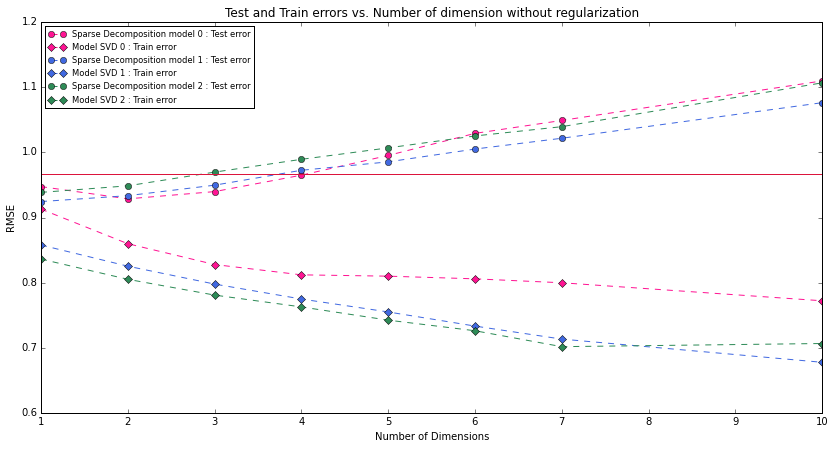

In [8]:
# Load disk saved results for the 3 different models

with open('results/B0_noreg_results.pkl', 'rb') as input:
    B0_test = pickle.load(input)
    B0_train = pickle.load(input)  
    
with open('results/B_noreg_results.pkl', 'rb') as input:
    B_test = pickle.load(input)
    B_train = pickle.load(input)  

with open('results/BT_noreg_results.pkl', 'rb') as input:
    BT_test = pickle.load(input)
    BT_train = pickle.load(input)

ndims = [1, 2, 3, 4, 5, 6, 7, 10]

fig = plt.figure()
plt.plot(ndims, B0_test, linestyle="dashed", marker="o", color='deeppink')
plt.plot(ndims, B0_train, linestyle="--", marker="D", color='deeppink')
plt.plot(ndims, B_test, linestyle="--", marker="o", color='royalblue')
plt.plot(ndims, B_train, linestyle="--", marker="D", color='royalblue')
plt.plot(ndims, BT_test, linestyle="--", marker="o", color='seagreen')
plt.plot(ndims, BT_train, linestyle="--", marker="D", color='seagreen')
plt.title("Test and Train errors vs. Number of dimension without regularization")
plt.xlabel("Number of Dimensions")
plt.ylabel("RMSE")
plt.legend(["Sparse Decomposition model 1 : Test error", "Sparse Decomposition model 1 : Train error", 
            "Sparse Decomposition model 2 : Test error", "Sparse Decomposition model 2 : Train error",
            "Sparse Decomposition model 3 : Test error", "Sparse Decomposition model 3 : Train error"], 2, fontsize='small')
plt.axhline(y=0.966803427233, xmin=0, xmax=20, linewidth=1, color='crimson')

## Model 2 (with non temporal biases terms) with regularization performances

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


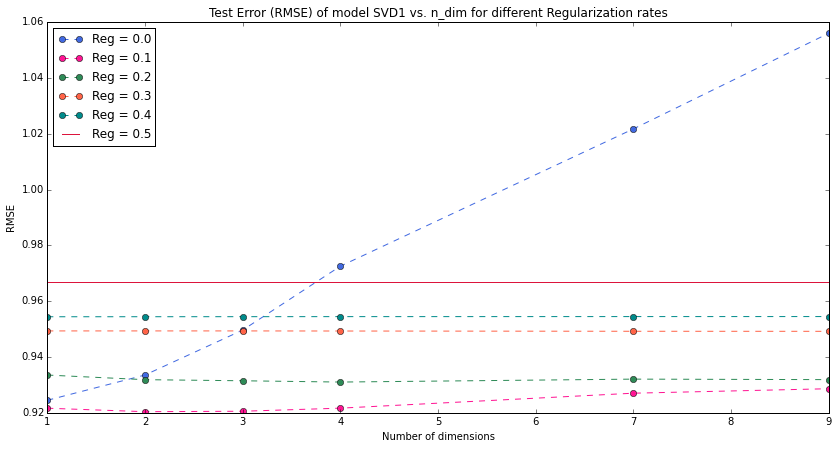

In [24]:
# Load Python dictionary containing results for model wih Bias (1)
# and different regularization parameters
with open('B_reg_results.pkl', 'rb') as input:
    B_reg_test = pickle.load(input)
    B_reg_train = pickle.load(input)

# Construct results lists 
# 1 list by different regularization parameter tested for different dimensions
B_reg_00_test = []
B_reg_01_test = []
B_reg_02_test = []
B_reg_03_test = []
B_reg_04_test = []
B_reg_05_test = []

for key in sorted(B_reg_test.keys()):
    if key[1] == 0.0:
        B_reg_00_test.append(B_reg_test[key])
    if key[1] == 0.1:
        B_reg_01_test.append(B_reg_test[key])
    if key[1] == 0.2:
        B_reg_02_test.append(B_reg_test[key])
    if key[1] == 0.3:
        B_reg_03_test.append(B_reg_test[key])
    if key[1] == 0.4:
        B_reg_04_test.append(B_reg_test[key])
    if key[1] == 0.5:
        B_reg_05_test.append(B_reg_test[key])

B_reg_00_train = []
B_reg_01_train = []
B_reg_02_train = []
B_reg_03_train = []
B_reg_04_train = []
B_reg_05_train = []

for key in sorted(B_reg_train.keys()):
    if key[1] == 0.0:
        B_reg_00_train.append(B_reg_train[key])
    if key[1] == 0.1:
        B_reg_01_train.append(B_reg_train[key])
    if key[1] == 0.2:
        B_reg_02_train.append(B_reg_train[key])
    if key[1] == 0.3:
        B_reg_03_train.append(B_reg_train[key])
    if key[1] == 0.4:
        B_reg_04_train.append(B_reg_train[key])
    if key[1] == 0.5:
        B_reg_05_train.append(B_reg_train[key])
ndims = [1, 2, 3, 4, 7, 9]

fig = plt.figure()
plt.plot(ndims, B_reg_00_test, linestyle="dashed", marker="o", color='royalblue')
plt.plot(ndims, B_reg_01_test, linestyle="dashed", marker="o", color='deeppink')
plt.plot(ndims, B_reg_02_test, linestyle="dashed", marker="o", color='seagreen')
plt.plot(ndims, B_reg_03_test, linestyle="dashed", marker="o", color='tomato')
plt.plot(ndims, B_reg_04_test, linestyle="dashed", marker="o", color='darkcyan')
plt.axhline(y=0.966803427233, xmin=0, xmax=20, linewidth=1, color='crimson')

plt.title('Test Error (RMSE) of model SVD1 vs. n_dim for different Regularization rates')
plt.xlabel('Number of dimensions')
plt.ylabel('RMSE')
plt.legend(['Reg = 0.0', 'Reg = 0.1', 'Reg = 0.2', 'Reg = 0.3', 'Reg = 0.4', 'Reg = 0.5'], 2)

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


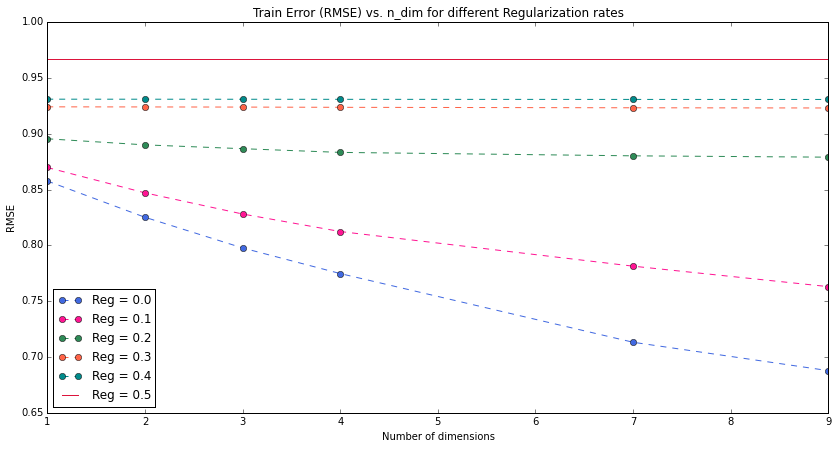

In [25]:
fig = plt.figure()
plt.plot(ndims, B_reg_00_train, linestyle="dashed", marker="o", color='royalblue')
plt.plot(ndims, B_reg_01_train, linestyle="dashed", marker="o", color='deeppink')
plt.plot(ndims, B_reg_02_train, linestyle="dashed", marker="o", color='seagreen')
plt.plot(ndims, B_reg_03_train, linestyle="dashed", marker="o", color='tomato')
plt.plot(ndims, B_reg_04_train, linestyle="dashed", marker="o", color='darkcyan')
plt.title('Train Error (RMSE) vs. n_dim for different Regularization rates')
plt.axhline(y=0.966803427233, xmin=0, xmax=20, linewidth=1, color='crimson')

plt.xlabel('Number of dimensions')
plt.ylabel('RMSE')
plt.legend(['Reg = 0.0', 'Reg = 0.1', 'Reg = 0.2', 'Reg = 0.3', 'Reg = 0.4', 'Reg = 0.5'], 3)

## Latent factors visualization

### Best Model found visualization

In [26]:
ndim = 2
batch_indexes = make_bins_i(len(obs_ui), 200)
p_init = np.random.rand(n_users, ndim) - 0.5
q_init = np.random.rand(n_items, ndim) - 0.5
bu_init = bu_init0
bi_init = bi_init0
mu_init = np.mean(obs_rates)

lrate = 0.1
reg = 0.1

(p, q, bu, bi, mu) = sgd_svdB(lrate, obs_ui, obs_rates, reg, batch_indexes,
                                q_init, p_init, bu_init, bi_init, mu_init)

**Visualization of items in extreme regions of latent dimensions space**

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


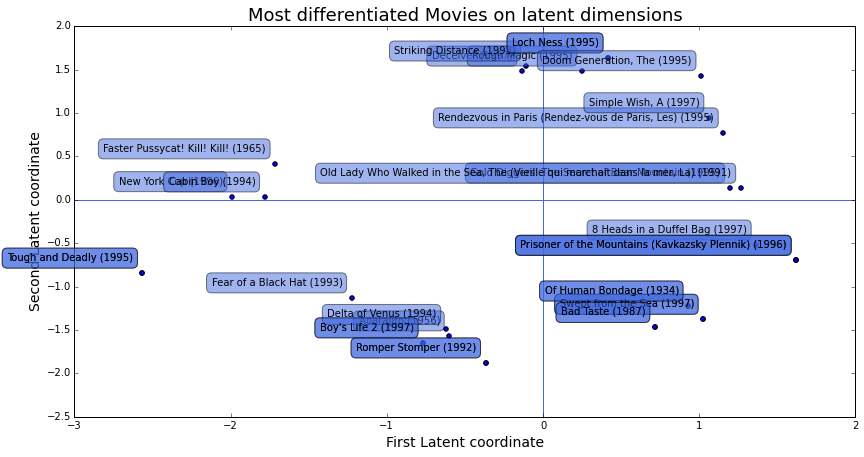

In [27]:
m_latent = q

# Compute set of items corresponding to extreme region of latent
# dimensions space

set1 = np.argsort(m_latent[:,0])[0:4]
set2 = np.argsort(m_latent[:,0])[-4:]
set3 = np.argsort(m_latent[:,1])[0:4]
set4 = np.argsort(m_latent[:,1])[-4:]
set5 = np.argsort(m_latent[:,1] + m_latent[:,0])[0:4]
set6 = np.argsort(m_latent[:,1] + m_latent[:,0])[-4:]
set7 = np.argsort(m_latent[:,1] - m_latent[:,0])[0:4]
set8 = np.argsort(m_latent[:,1] - m_latent[:,0])[-4:]
set9 = np.argsort(abs(m_latent[:,1] + m_latent[:,0]))[0:4]
fullset = np.append(set1, [set2, set3, set4, set5, set6, set7, set7])

labels = itemsdf.ix[fullset, ' movie title ']
m_latent = m_latent[fullset,]

plt.scatter(x=m_latent[:,0], y=m_latent[:,1], marker='o')
for label, x, y in zip(labels, m_latent[:, 0], m_latent[:, 1]):
    plt.annotate(
        label,
        fontsize=10,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')
plt.title('Most differentiated Movies on latent dimensions', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

**Visualization of repartiton of most rated items in latent dimensions space**

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


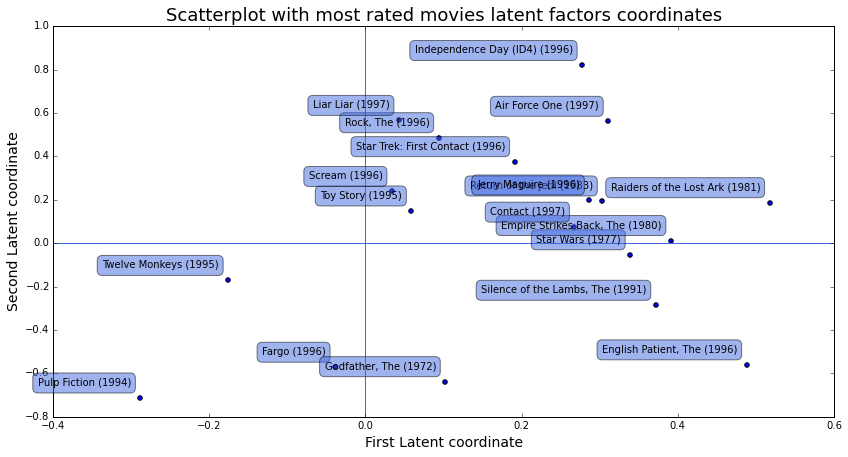

In [28]:
m_latent = q

# Construct votes_by_movie feature and corresponding movies indices set
votes_by_movie = dict(ratings.groupby('item.id')['rating'].count())
itemsdf['votes_by_item'] = itemsdf['movie id '].apply(lambda x: votes_by_movie[x])
max_votes_ix = itemsdf[itemsdf['votes_by_item'] > 360].index
labels = itemsdf.ix[itemsdf['votes_by_item'] > 360, ' movie title ']

plt.scatter(x=m_latent[max_votes_ix,0], y=m_latent[max_votes_ix,1], marker='o')
for label, x, y in zip(labels, m_latent[max_votes_ix, 0], m_latent[max_votes_ix, 1]):
    plt.annotate(
        label,
        fontsize=10,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')
plt.title('Scatterplot with most rated movies latent factors coordinates', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

**Visualization of movie types in latent dimensions space**

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


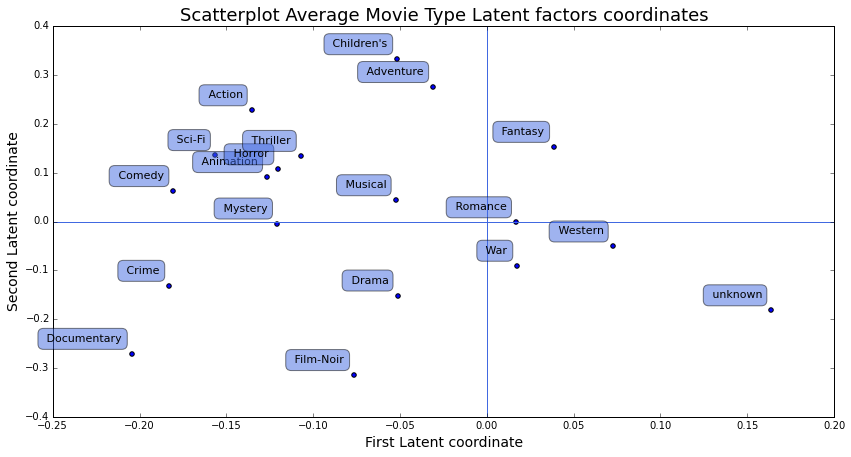

In [29]:
labels = itemsdf.columns[5:-2]
first = []
second = []

for column in itemsdf.columns[5:-2]:
    ix = itemsdf.ix[itemsdf[column] == 1,].index
    mean = np.mean(m_latent[ix,:], axis=0)
    first.append(mean[0])
    second.append(mean[1])
    
plt.scatter(x=first, y=second, marker='o')
for label, x, y in zip(labels, first, second):
    plt.annotate(
        label,
        fontsize=11,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')

plt.title('Scatterplot Average Movie Type Latent factors coordinates', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

### Model 2 with 10 dimensions visualization (2 dimensions with most variance)

In [37]:
ndim = 10
batch_indexes = make_bins_i(len(obs_ui), 200)
p_init = np.random.rand(n_users, ndim) - 0.5
q_init = np.random.rand(n_items, ndim) - 0.5
bu_init = bu_init0
bi_init = bi_init0
mu_init = np.mean(obs_rates)

lrate = 0.1
reg = 0.1

(p10, q10, bu10, bi10, mu) = sgd_svdB(lrate, obs_ui, obs_rates, reg, batch_indexes,
                                q_init, p_init, bu_init, bi_init, mu_init)

**Most rated movies**

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


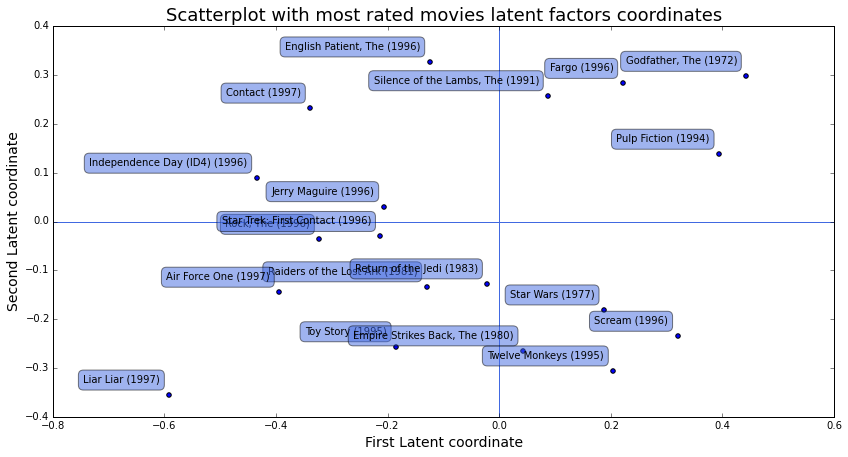

In [38]:
m_latent = q10
np.var(q10, axis=0)
m_latent = m_latent[:,[2,5]]

max_votes_ix = itemsdf[itemsdf['votes_by_item'] > 360].index
labels = itemsdf.ix[itemsdf['votes_by_item'] > 360, ' movie title ']

plt.scatter(x=m_latent[max_votes_ix,0], y=m_latent[max_votes_ix,1], marker='o')
for label, x, y in zip(labels, m_latent[max_votes_ix, 0], m_latent[max_votes_ix, 1]):
    plt.annotate(
        label,
        fontsize=10,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')
plt.title('Scatterplot with most rated movies latent factors coordinates', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

** Movie types **

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


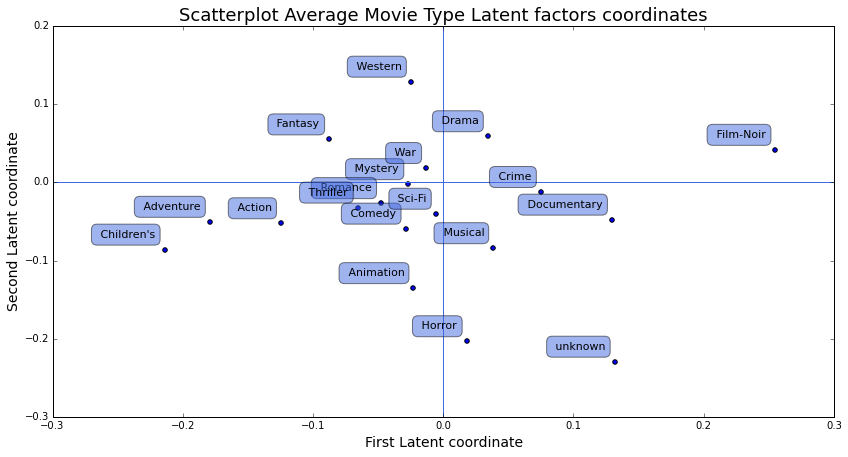

In [39]:
labels = itemsdf.columns[5:-2]
first = []
second = []

for column in itemsdf.columns[5:-2]:
    ix = itemsdf.ix[itemsdf[column] == 1,].index
    mean = np.mean(m_latent[ix,:], axis=0)
    first.append(mean[0])
    second.append(mean[1])
    
plt.scatter(x=first, y=second, marker='o')
for label, x, y in zip(labels, first, second):
    plt.annotate(
        label,
        fontsize=11,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')

plt.title('Scatterplot Average Movie Type Latent factors coordinates', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

**Extreme regions movies**

In [ ]:
max_votes_ix = itemsdf[itemsdf['votes_by_item'] > 215].index

set1 = np.argsort(m_latent[:,0])[0:4]
set2 = np.argsort(m_latent[:,0])[-4:]
set3 = np.argsort(m_latent[:,1])[0:4]
set4 = np.argsort(m_latent[:,1])[-4:]
set5 = np.argsort(m_latent[:,1] + m_latent[:,0])[0:4]
set6 = np.argsort(m_latent[:,1] + m_latent[:,0])[-4:]
set7 = np.argsort(m_latent[:,1] - m_latent[:,0])[0:4]
set8 = np.argsort(m_latent[:,1] - m_latent[:,0])[-4:]
set9 = np.argsort(abs(m_latent[:,1] + m_latent[:,0]))[0:4]
fullset = np.append(set1, [set2, set3, set4, set5, set6, set7, set7])

labels = itemsdf.ix[fullset, ' movie title ']
m_latent = m_latent[fullset,]

plt.scatter(x=m_latent[:,0], y=m_latent[:,1], marker='o')
for label, x, y in zip(labels, m_latent[:, 0], m_latent[:, 1]):
    plt.annotate(
        label,
        fontsize=10,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')
plt.title('Most differentiated Movies on latent dimensions')
plt.xlabel('First Latent coordinate')
plt.ylabel('Second Latent coordinate')